
## https://challenge.isic-archive.com/data/

In [ ]:
import os
if os.path.exists('/content/drive'):
  pass
else:
  from google.colab import drive
  drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!nvidia-smi

Sat Dec 23 07:46:34 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-SXM2-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0              23W / 300W |      0MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# I. download data

In [ ]:
!pwd

/content


In [ ]:
link_data = ['https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task1_Training_GroundTruth.zip',
'https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task2_Training_GroundTruth_v3.zip',
'https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task1-2_Validation_Input.zip',
'https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task1_Validation_GroundTruth.zip',
'https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task2_Validation_GroundTruth.zip',
'https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task1-2_Test_Input.zip',
'https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task1-2_Training_Input.zip',
'https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task1_Test_GroundTruth.zip']
dowload_data = True
folder_zip = '/content'
folder_save = '/content/data'
if dowload_data:
  for i in link_data:
    !wget $i
    name = i.split('/')[-1]
    file_zip =  folder_zip + '/' + name
    !unzip $file_zip -d $folder_save


# # 'https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task3_Training_GroundTruth.zip',
# # 'https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task3_Validation_Input.zip',
# # 'https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task3_Test_Input.zip',
# # 'https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task3_Test_GroundTruth.zip',



Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
  inflating: /content/data/ISIC2018_Task2_Validation_GroundTruth/ISIC_0018111_attribute_globules.png  
  inflating: /content/data/ISIC2018_Task2_Validation_GroundTruth/ISIC_0018111_attribute_milia_like_cyst.png  
  inflating: /content/data/ISIC2018_Task2_Validation_GroundTruth/ISIC_0018111_attribute_negative_network.png  
  inflating: /content/data/ISIC2018_Task2_Validation_GroundTruth/ISIC_0018111_attribute_pigment_network.png  
  inflating: /content/data/ISIC2018_Task2_Validation_GroundTruth/ISIC_0018111_attribute_streaks.png  
  inflating: /content/data/ISIC2018_Task2_Validation_GroundTruth/ISIC_0018179_attribute_globules.png  
  inflating: /content/data/ISIC2018_Task2_Validation_GroundTruth/ISIC_0018179_attribute_milia_like_cyst.png  
  inflating: /content/data/ISIC2018_Task2_Validation_GroundTruth/ISIC_0018179_attribute_negative_network.png  
  inflating: /content/data/ISIC2018_Task2_Validation_GroundTruth/ISIC_0018179_attri

# II. code

In [ ]:
!pip install torchmetrics
!pip install segmentation_models_pytorch
!pip install albumentations
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 18.9 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=b27f6b9702aa00a7f7a1ac1cdef3d245c5caf6d1c5df5697088b41edc37094d6
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=1a22ea133067d39cc950caa0808166da10488cbcbb051e2c64c50cd19e1def43
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-p

In [ ]:
import os
import cv2
import glob
import torch
import numpy as np
import torchmetrics
import torch.nn as nn
import albumentations as A
import torch.nn.functional as F
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp

from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from albumentations.pytorch import ToTensorV2

In [ ]:
class SkinImage(Dataset):
  def __init__(self, image_folder, mask_folder, transform=None):
    super().__init__()
    self.image_folder = image_folder
    self.mask_folder = mask_folder
    self.transform = transform
    self.images_path = glob.glob(image_folder + '/*.jpg')
    self.images_path.sort()
    self.maskes_path = glob.glob(mask_folder + '/*.png')
    self.maskes_path.sort()
    print(len(self.images_path),len(self.maskes_path))

  def __len__(self):
    if len(self.images_path) == len(self.maskes_path):
      return len(self.images_path)
    return 0

  def __getitem__(self, idx):
    image_path = self.images_path[idx]
    mask_path = self.maskes_path[idx]
    if image_path.split('/')[-1][:-4] not in mask_path:
      return None, None
    else:
      image = cv2.imread(image_path)
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
      mask = mask / 255


      if self.transform is not None:
        transformed = self.transform(image=image, mask=mask)
        transformed_image = transformed['image']
        transformed_mask = transformed['mask']
        return transformed_image, transformed_mask
      return image, mask



In [ ]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor

unorm = UnNormalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))

In [ ]:
trainsize = 512

train_transform = A.Compose([
    A.Resize(width=trainsize, height=trainsize),
    A.RandomBrightnessContrast(),
    A.Sharpen(),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0),
    ToTensorV2(),
])

test_transform = A.Compose([
    A.Resize(width=trainsize, height=trainsize),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0),
    ToTensorV2(), # numpy.array -> torch.tensor (B, 3, H, W)
])

In [ ]:
train_images = '/content/data/ISIC2018_Task1-2_Training_Input'
train_maskes = '/content/data/ISIC2018_Task1_Training_GroundTruth'
val_images = '/content/data/ISIC2018_Task1-2_Validation_Input'
val_maskes = '/content/data/ISIC2018_Task1_Validation_GroundTruth'
test_images = '/content/data/ISIC2018_Task1-2_Test_Input'
test_maskes = '/content/data/ISIC2018_Task1_Test_GroundTruth'

In [ ]:
dataset_train = SkinImage(train_images, train_maskes, train_transform)
dataset_val = SkinImage(val_images, val_maskes, train_transform)
dataset_test = SkinImage(test_images, test_maskes, test_transform)
print(dataset_train.__len__(),dataset_val.__len__(),dataset_test.__len__())


2594 2594
100 100
1000 1000
2594 100 1000


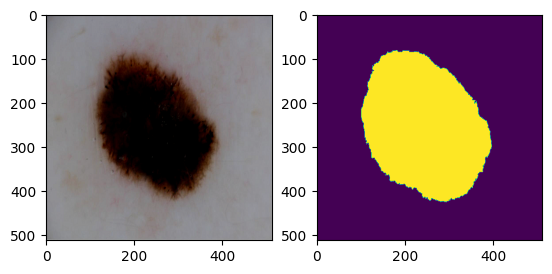

In [ ]:
image, mask = dataset_train.__getitem__(10)
image = unorm(image).permute(1,2,0)
plt.subplot(1,2,1)
plt.imshow(image)
plt.subplot(1,2,2)
plt.imshow(mask)
plt.show()

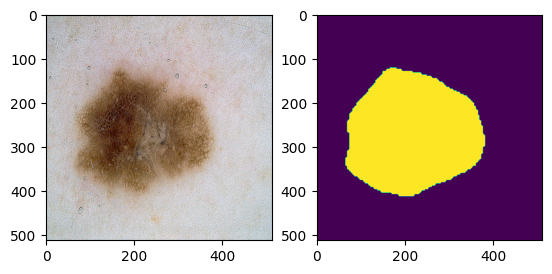

In [ ]:
image, mask = dataset_val.__getitem__(10)
image = unorm(image).permute(1,2,0)
plt.subplot(1,2,1)
plt.imshow(image)
plt.subplot(1,2,2)
plt.imshow(mask)
plt.show()

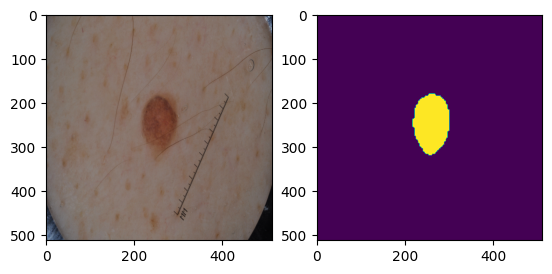

In [ ]:
image, mask = dataset_test.__getitem__(10)
image = unorm(image).permute(1,2,0)
plt.subplot(1,2,1)
plt.imshow(image)
plt.subplot(1,2,2)
plt.imshow(mask)
plt.show()

In [ ]:
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
#metrics
def intersectionAndUnionGPU(output, target, K, ignore_index=255):
    # 'K' classes, output and target sizes are N or N * L or N * H * W, each value in range 0 to K - 1.
    assert (output.dim() in [1, 2, 3])
    assert output.shape == target.shape
    output = output.view(-1)
    target = target.view(-1)
    output[target == ignore_index] = ignore_index
    intersection = output[output == target]
    area_intersection = torch.histc(intersection, bins=K, min=0, max=K-1)
    area_output = torch.histc(output, bins=K, min=0, max=K-1)
    area_target = torch.histc(target, bins=K, min=0, max=K-1)
    area_union = area_output + area_target - area_intersection
    return area_intersection, area_union, area_target

In [ ]:
from transformers import SegformerForSemanticSegmentation

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#load data
n_class = 2
batch_size = 4
n_workers = os.cpu_count()
print("num_workers =", n_workers)
trainloader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size,
                                          shuffle=True, num_workers=n_workers)
valloader = torch.utils.data.DataLoader(dataset_val, batch_size=batch_size,
                                            shuffle=False, num_workers=n_workers)
testloader = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size,
                                          shuffle=False, num_workers=n_workers)

#model
model = SegformerForSemanticSegmentation.from_pretrained("nvidia/segformer-b4-finetuned-ade-512-512").to(device)

#loss
# criterion = smp.losses.DiceLoss(mode="multiclass", classes=21)
criterion = nn.CrossEntropyLoss()

#optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


#meter
train_loss_meter = AverageMeter()
intersection_meter = AverageMeter()
union_meter = AverageMeter()
target_meter = AverageMeter()

num_workers = 8


In [ ]:
%cd /content/drive/MyDrive/KLTN
n_eps = 50

/content/drive/MyDrive/KLTN


In [ ]:
current_iou = 0
import time

for ep in range(1, 1+n_eps):
    time_start = time.time()
    train_loss_meter.reset()
    intersection_meter.reset()
    union_meter.reset()
    target_meter.reset()
    model.train()

    for batch_id, (x, y) in enumerate(tqdm(trainloader), start=1):
        optimizer.zero_grad()
        n = x.shape[0]
        x = x.to(device).float()
        y = y.to(device).long()
        y_hat = model(x).logits #(B, C, H, W)
        y_hat = F.interpolate(y_hat, y.shape[1:], mode="bilinear")
        loss = criterion(y_hat, y) #(B, C, H, W) >< (B, H, W)
        loss.backward()
        optimizer.step()

        #save metrics
        with torch.no_grad():
            train_loss_meter.update(loss.item())
            y_hat_mask = y_hat.argmax(dim=1).squeeze(1) # (B, C, H, W) -> (B, 1, H, W) -> (B, H, W)
            intersection, union, target = intersectionAndUnionGPU(y_hat_mask.float(), y.float(), n_class)
            intersection_meter.update(intersection)
            union_meter.update(union)
            target_meter.update(target)

    #compute iou, dice
    with torch.no_grad():
        iou_class = intersection_meter.sum / (union_meter.sum + 1e-10) #vector n_classD
        dice_class = (2 * intersection_meter.sum) / (intersection_meter.sum + union_meter.sum + 1e-10) #vector n_classD

        mIoU = torch.mean(iou_class) #mean vector n_classD
        mDice = torch.mean(dice_class) #mean vector n_classD
        train_loss_meter_save = train_loss_meter.avg
        train_mIoU_save = mIoU
        train_mDice_save = mDice

        # val loss
        val_loss_meter = AverageMeter()
        intersection_meter.reset()
        union_meter.reset()
        target_meter.reset()
        model.eval()
        for batch_id, (x, y) in enumerate(valloader, start=1):
            n = x.shape[0]
            x = x.to(device).float()
            y = y.to(device).long()
            y_hat = model(x).logits
            y_hat = F.interpolate(y_hat, y.shape[1:], mode="bilinear")
            loss = criterion(y_hat, y)

            #save metrics
            val_loss_meter.update(loss.item())
            y_hat_mask = y_hat.argmax(dim=1).squeeze(1)
            intersection, union, target = intersectionAndUnionGPU(y_hat_mask.float(), y.float(), n_class)
            intersection_meter.update(intersection)
            union_meter.update(union)
            target_meter.update(target)

        #compute iou, dice
        iou_class = intersection_meter.sum / (union_meter.sum + 1e-10)
        dice_class = (2 * intersection_meter.sum) / (intersection_meter.sum + union_meter.sum + 1e-10)
        mIoU = torch.mean(iou_class)
        mDice = torch.mean(dice_class)
        print("EP {}, train loss = {} IoU = {}, dice = {}".format(ep, train_loss_meter_save, train_mIoU_save, train_mDice_save))
        print("EP {}, val loss = {} IoU = {}, dice = {}".format(ep, val_loss_meter.avg, mIoU, mDice))



    if mIoU > current_iou:
        current_iou = mIoU
        torch.save(model.state_dict(), "modelSegformer_best.pth")
    # if ep >= 40:
    #     torch.save(model.state_dict(), "modelFPN1_ep_{}.pth".format(ep))
    torch.save(model.state_dict(), "modelSegformer_current.pth")
    time_end = time.time()
    print("Time predict: ", (time_end - time_start)//3600, " hours", (time_end - time_start)%3600//60, " minutes", np.round((time_end - time_start)%3600%60, 2), " seconds")


100%|██████████| 649/649 [04:44<00:00,  2.28it/s]


EP 1, train loss = 0.2269025559326166 IoU = 0.836991548538208, dice = 0.9088219404220581
EP 1, val loss = 0.12344165742397309 IoU = 0.8745284676551819, dice = 0.9320876598358154
Time predict:  0.0  hours 4.0  minutes 53.97  seconds


100%|██████████| 649/649 [04:44<00:00,  2.28it/s]


EP 2, train loss = 0.10528358549040345 IoU = 0.8891879320144653, dice = 0.9402081966400146
EP 2, val loss = 0.15586398795247078 IoU = 0.8345072865486145, dice = 0.9084237217903137
Time predict:  0.0  hours 4.0  minutes 53.55  seconds


100%|██████████| 649/649 [04:44<00:00,  2.28it/s]


EP 3, train loss = 0.0919946451859408 IoU = 0.9022645950317383, dice = 0.9477531909942627
EP 3, val loss = 0.15067276693880557 IoU = 0.8708035945892334, dice = 0.9298877120018005
Time predict:  0.0  hours 4.0  minutes 53.61  seconds


100%|██████████| 649/649 [04:43<00:00,  2.29it/s]


EP 4, train loss = 0.08738670305267138 IoU = 0.9052395820617676, dice = 0.9494513273239136
EP 4, val loss = 0.14209171898663045 IoU = 0.8581233024597168, dice = 0.9225796461105347
Time predict:  0.0  hours 4.0  minutes 52.4  seconds


100%|██████████| 649/649 [04:44<00:00,  2.28it/s]


EP 5, train loss = 0.07006298743750906 IoU = 0.9203753471374512, dice = 0.957973837852478
EP 5, val loss = 0.2252662833034992 IoU = 0.8185244798660278, dice = 0.898854672908783
Time predict:  0.0  hours 4.0  minutes 53.42  seconds


100%|██████████| 649/649 [04:44<00:00,  2.28it/s]


EP 6, train loss = 0.06802947484875221 IoU = 0.9201161861419678, dice = 0.9578326940536499
EP 6, val loss = 0.13278869569301605 IoU = 0.8710479736328125, dice = 0.9302212595939636
Time predict:  0.0  hours 4.0  minutes 53.7  seconds


100%|██████████| 649/649 [04:44<00:00,  2.28it/s]


EP 7, train loss = 0.0745119804570965 IoU = 0.9173092842102051, dice = 0.9562627077102661
EP 7, val loss = 0.13966426700353624 IoU = 0.8638465404510498, dice = 0.9259475469589233
Time predict:  0.0  hours 4.0  minutes 53.62  seconds


100%|██████████| 649/649 [04:43<00:00,  2.29it/s]


EP 8, train loss = 0.059756063729903455 IoU = 0.9294344782829285, dice = 0.9629899263381958
EP 8, val loss = 0.160219696611166 IoU = 0.860695481300354, dice = 0.9240959286689758
Time predict:  0.0  hours 4.0  minutes 51.92  seconds


100%|██████████| 649/649 [04:45<00:00,  2.27it/s]


EP 9, train loss = 0.05304429311024022 IoU = 0.9363617300987244, dice = 0.96678227186203
EP 9, val loss = 0.1765052639693022 IoU = 0.8472391366958618, dice = 0.9161586165428162
Time predict:  0.0  hours 4.0  minutes 54.22  seconds


100%|██████████| 649/649 [04:45<00:00,  2.28it/s]


EP 10, train loss = 0.06439469724417146 IoU = 0.9254314303398132, dice = 0.9607812166213989
EP 10, val loss = 0.16999213695526122 IoU = 0.8465533256530762, dice = 0.9155713319778442
Time predict:  0.0  hours 4.0  minutes 53.68  seconds


100%|██████████| 649/649 [04:45<00:00,  2.28it/s]


EP 11, train loss = 0.07849521015574137 IoU = 0.911593496799469, dice = 0.9530524015426636
EP 11, val loss = 0.1431640800088644 IoU = 0.8732312917709351, dice = 0.9315185546875
Time predict:  0.0  hours 4.0  minutes 53.75  seconds


100%|██████████| 649/649 [04:45<00:00,  2.28it/s]


EP 12, train loss = 0.05202667380845281 IoU = 0.9378071427345276, dice = 0.9675694704055786
EP 12, val loss = 0.15485748901963234 IoU = 0.8669816255569458, dice = 0.9276992082595825
Time predict:  0.0  hours 4.0  minutes 53.94  seconds


100%|██████████| 649/649 [04:44<00:00,  2.28it/s]


EP 13, train loss = 0.04731546845057483 IoU = 0.9430893659591675, dice = 0.9704313278198242
EP 13, val loss = 0.17325987942516805 IoU = 0.8549887537956238, dice = 0.9207361340522766
Time predict:  0.0  hours 4.0  minutes 53.27  seconds


100%|██████████| 649/649 [04:45<00:00,  2.28it/s]


EP 14, train loss = 0.040741102666650056 IoU = 0.9502793550491333, dice = 0.9742940664291382
EP 14, val loss = 0.15629640139639378 IoU = 0.8803089261054993, dice = 0.9355490803718567
Time predict:  0.0  hours 4.0  minutes 55.15  seconds


100%|██████████| 649/649 [04:46<00:00,  2.27it/s]


EP 15, train loss = 0.04054898950048882 IoU = 0.9504997730255127, dice = 0.9744119048118591
EP 15, val loss = 0.1804482001811266 IoU = 0.8704532384872437, dice = 0.9297974705696106
Time predict:  0.0  hours 4.0  minutes 55.25  seconds


100%|██████████| 649/649 [04:45<00:00,  2.27it/s]


EP 16, train loss = 0.04692146122220255 IoU = 0.9445781707763672, dice = 0.9712348580360413
EP 16, val loss = 0.16704697526991366 IoU = 0.8529514074325562, dice = 0.9195596575737
Time predict:  0.0  hours 4.0  minutes 54.57  seconds


100%|██████████| 649/649 [04:45<00:00,  2.27it/s]


EP 17, train loss = 0.06838184684939763 IoU = 0.9247418642044067, dice = 0.9604013562202454
EP 17, val loss = 0.16902122423052787 IoU = 0.8518736362457275, dice = 0.9187551140785217
Time predict:  0.0  hours 4.0  minutes 54.42  seconds


100%|██████████| 649/649 [04:46<00:00,  2.27it/s]


EP 18, train loss = 0.047231881734333896 IoU = 0.9443374872207642, dice = 0.9711049199104309
EP 18, val loss = 0.14231969997286797 IoU = 0.8824101686477661, dice = 0.9368144273757935
Time predict:  0.0  hours 4.0  minutes 55.73  seconds


100%|██████████| 649/649 [04:44<00:00,  2.28it/s]


EP 19, train loss = 0.03540295703287806 IoU = 0.9564911723136902, dice = 0.9776006937026978
EP 19, val loss = 0.14196225747466087 IoU = 0.8820459842681885, dice = 0.9365721940994263
Time predict:  0.0  hours 4.0  minutes 53.65  seconds


100%|██████████| 649/649 [04:44<00:00,  2.28it/s]


EP 20, train loss = 0.03341417215930984 IoU = 0.9593856334686279, dice = 0.979131817817688
EP 20, val loss = 0.20374088734388351 IoU = 0.8651904463768005, dice = 0.9267355799674988
Time predict:  0.0  hours 4.0  minutes 53.05  seconds


100%|██████████| 649/649 [04:44<00:00,  2.28it/s]


EP 21, train loss = 0.03028971085235913 IoU = 0.9628582000732422, dice = 0.9809610843658447
EP 21, val loss = 0.19670777201652526 IoU = 0.874577522277832, dice = 0.9321855306625366
Time predict:  0.0  hours 4.0  minutes 53.52  seconds


100%|██████████| 649/649 [04:44<00:00,  2.28it/s]


EP 22, train loss = 0.029267101065730692 IoU = 0.9638001918792725, dice = 0.9814557433128357
EP 22, val loss = 0.20131120830774307 IoU = 0.8727589845657349, dice = 0.9311712980270386
Time predict:  0.0  hours 4.0  minutes 53.11  seconds


100%|██████████| 649/649 [04:43<00:00,  2.29it/s]


EP 23, train loss = 0.046527762498379394 IoU = 0.9462847709655762, dice = 0.9721529483795166
EP 23, val loss = 0.17524517059326172 IoU = 0.8328967690467834, dice = 0.9071678519248962
Time predict:  0.0  hours 4.0  minutes 52.86  seconds


100%|██████████| 649/649 [04:44<00:00,  2.28it/s]


EP 24, train loss = 0.048788052405272314 IoU = 0.9433636665344238, dice = 0.9705798625946045
EP 24, val loss = 0.253281676620245 IoU = 0.8491039276123047, dice = 0.9170622825622559
Time predict:  0.0  hours 4.0  minutes 53.45  seconds


100%|██████████| 649/649 [04:44<00:00,  2.28it/s]


EP 25, train loss = 0.030766224204483678 IoU = 0.9622334241867065, dice = 0.9806325435638428
EP 25, val loss = 0.22043413162231446 IoU = 0.8627274036407471, dice = 0.9252535104751587
Time predict:  0.0  hours 4.0  minutes 53.48  seconds


100%|██████████| 649/649 [04:45<00:00,  2.28it/s]


EP 26, train loss = 0.02588503270371256 IoU = 0.9678382873535156, dice = 0.9835692644119263
EP 26, val loss = 0.30144151717424394 IoU = 0.8601796627044678, dice = 0.9236321449279785
Time predict:  0.0  hours 4.0  minutes 53.9  seconds


100%|██████████| 649/649 [04:44<00:00,  2.28it/s]


EP 27, train loss = 0.024736324697589424 IoU = 0.9692115187644958, dice = 0.9842854738235474
EP 27, val loss = 0.24381198421120642 IoU = 0.8628569841384888, dice = 0.9253051280975342
Time predict:  0.0  hours 4.0  minutes 52.83  seconds


100%|██████████| 649/649 [04:45<00:00,  2.27it/s]


EP 28, train loss = 0.061846639590771246 IoU = 0.9329121112823486, dice = 0.9648975133895874
EP 28, val loss = 0.15157406963407993 IoU = 0.8782672882080078, dice = 0.9344145655632019
Time predict:  0.0  hours 4.0  minutes 54.63  seconds


100%|██████████| 649/649 [04:44<00:00,  2.28it/s]


EP 29, train loss = 0.03787404991031979 IoU = 0.9542832374572754, dice = 0.9764288067817688
EP 29, val loss = 0.19773713558912276 IoU = 0.8630479574203491, dice = 0.9254522323608398
Time predict:  0.0  hours 4.0  minutes 53.26  seconds


100%|██████████| 649/649 [04:44<00:00,  2.28it/s]


EP 30, train loss = 0.02678395792173196 IoU = 0.9668810367584229, dice = 0.9830693602561951
EP 30, val loss = 0.24016151040792466 IoU = 0.8582866191864014, dice = 0.922606885433197
Time predict:  0.0  hours 4.0  minutes 52.96  seconds


100%|██████████| 649/649 [04:43<00:00,  2.29it/s]


EP 31, train loss = 0.022983453494822392 IoU = 0.971298336982727, dice = 0.9853711128234863
EP 31, val loss = 0.25323877975344655 IoU = 0.8617823123931885, dice = 0.9247053861618042
Time predict:  0.0  hours 4.0  minutes 52.75  seconds


100%|██████████| 649/649 [04:45<00:00,  2.28it/s]


EP 32, train loss = 0.04122482391809026 IoU = 0.9519072771072388, dice = 0.9751635789871216
EP 32, val loss = 0.15417465552687645 IoU = 0.8825396299362183, dice = 0.9368581771850586
Time predict:  0.0  hours 4.0  minutes 55.63  seconds


100%|██████████| 649/649 [04:46<00:00,  2.26it/s]


EP 33, train loss = 0.02734213132477252 IoU = 0.9663161039352417, dice = 0.9827739596366882
EP 33, val loss = 0.19248927250504494 IoU = 0.8785372972488403, dice = 0.9345293641090393
Time predict:  0.0  hours 4.0  minutes 55.52  seconds


100%|██████████| 649/649 [04:45<00:00,  2.28it/s]


EP 34, train loss = 0.022267114326575962 IoU = 0.9721866846084595, dice = 0.9858324527740479
EP 34, val loss = 0.23707822635769843 IoU = 0.8683462738990784, dice = 0.9285749197006226
Time predict:  0.0  hours 4.0  minutes 54.21  seconds


100%|██████████| 649/649 [04:46<00:00,  2.27it/s]


EP 35, train loss = 0.020615104849210645 IoU = 0.9742081165313721, dice = 0.9868799448013306
EP 35, val loss = 0.22178514070808888 IoU = 0.8839088678359985, dice = 0.9376511573791504
Time predict:  0.0  hours 4.0  minutes 56.34  seconds


100%|██████████| 649/649 [04:45<00:00,  2.28it/s]


EP 36, train loss = 0.026693494060580462 IoU = 0.9670161008834839, dice = 0.9831399321556091
EP 36, val loss = 0.25531339794397356 IoU = 0.8635732531547546, dice = 0.9257079362869263
Time predict:  0.0  hours 4.0  minutes 54.11  seconds


100%|██████████| 649/649 [04:46<00:00,  2.26it/s]


EP 37, train loss = 0.02355722067604998 IoU = 0.9706209897994995, dice = 0.9850190877914429
EP 37, val loss = 0.23581257417798043 IoU = 0.8765878677368164, dice = 0.9334105253219604
Time predict:  0.0  hours 4.0  minutes 55.63  seconds


100%|██████████| 649/649 [04:46<00:00,  2.26it/s]


EP 38, train loss = 0.02146133138885713 IoU = 0.9734182953834534, dice = 0.9864709377288818
EP 38, val loss = 0.2537152595818043 IoU = 0.8692259788513184, dice = 0.929148256778717
Time predict:  0.0  hours 4.0  minutes 55.55  seconds


100%|██████████| 649/649 [04:46<00:00,  2.27it/s]


EP 39, train loss = 0.020006011021345027 IoU = 0.9748857021331787, dice = 0.9872304201126099
EP 39, val loss = 0.25789086155593394 IoU = 0.8710524439811707, dice = 0.9301435947418213
Time predict:  0.0  hours 4.0  minutes 55.04  seconds


100%|██████████| 649/649 [04:45<00:00,  2.27it/s]


EP 40, train loss = 0.05511672684681732 IoU = 0.9392513036727905, dice = 0.9683533906936646
EP 40, val loss = 0.22454240247607232 IoU = 0.820664644241333, dice = 0.9000648260116577
Time predict:  0.0  hours 4.0  minutes 55.04  seconds


100%|██████████| 649/649 [04:45<00:00,  2.27it/s]


EP 41, train loss = 0.03757909972806144 IoU = 0.9546518325805664, dice = 0.9766247272491455
EP 41, val loss = 0.1878166465461254 IoU = 0.866854727268219, dice = 0.9277316927909851
Time predict:  0.0  hours 4.0  minutes 54.64  seconds


100%|██████████| 649/649 [04:45<00:00,  2.27it/s]


EP 42, train loss = 0.02248255709166106 IoU = 0.9721051454544067, dice = 0.9857900142669678
EP 42, val loss = 0.22998335227370262 IoU = 0.870499849319458, dice = 0.9299229979515076
Time predict:  0.0  hours 4.0  minutes 54.99  seconds


100%|██████████| 649/649 [04:43<00:00,  2.29it/s]


EP 43, train loss = 0.019536408013126057 IoU = 0.975650429725647, dice = 0.9876257181167603
EP 43, val loss = 0.22275524340569974 IoU = 0.8809846639633179, dice = 0.9359729290008545
Time predict:  0.0  hours 4.0  minutes 52.61  seconds


100%|██████████| 649/649 [04:44<00:00,  2.28it/s]


EP 44, train loss = 0.017572088536586847 IoU = 0.9779465794563293, dice = 0.9888098239898682
EP 44, val loss = 0.2516173929721117 IoU = 0.8769940137863159, dice = 0.9336727261543274
Time predict:  0.0  hours 4.0  minutes 53.02  seconds


100%|██████████| 649/649 [04:44<00:00,  2.28it/s]


EP 45, train loss = 0.017137752224523316 IoU = 0.9784485101699829, dice = 0.9890682101249695
EP 45, val loss = 0.2389846969395876 IoU = 0.8725257515907288, dice = 0.9310650825500488
Time predict:  0.0  hours 4.0  minutes 53.3  seconds


100%|██████████| 649/649 [04:42<00:00,  2.29it/s]


EP 46, train loss = 0.017806957599969555 IoU = 0.9777089357376099, dice = 0.9886873960494995
EP 46, val loss = 0.22185010462999344 IoU = 0.8605697154998779, dice = 0.9239585399627686
Time predict:  0.0  hours 4.0  minutes 51.66  seconds


100%|██████████| 649/649 [04:43<00:00,  2.29it/s]


EP 47, train loss = 0.056153073934881226 IoU = 0.938292384147644, dice = 0.9678342342376709
EP 47, val loss = 0.17947761170566082 IoU = 0.8670046329498291, dice = 0.927776038646698
Time predict:  0.0  hours 4.0  minutes 51.93  seconds


100%|██████████| 649/649 [04:44<00:00,  2.28it/s]


EP 48, train loss = 0.025544936742880404 IoU = 0.9686872959136963, dice = 0.9840121865272522
EP 48, val loss = 0.21383639469742774 IoU = 0.8586232662200928, dice = 0.9228150844573975
Time predict:  0.0  hours 4.0  minutes 52.87  seconds


100%|██████████| 649/649 [04:44<00:00,  2.28it/s]


EP 49, train loss = 0.01858432895470933 IoU = 0.9766709208488464, dice = 0.9881523847579956
EP 49, val loss = 0.2176694381982088 IoU = 0.8773676753044128, dice = 0.9338588118553162
Time predict:  0.0  hours 4.0  minutes 53.07  seconds


100%|██████████| 649/649 [04:42<00:00,  2.29it/s]


EP 50, train loss = 0.016686797350823006 IoU = 0.9790002107620239, dice = 0.9893519878387451
EP 50, val loss = 0.25024754405021665 IoU = 0.8723251223564148, dice = 0.9308804273605347
Time predict:  0.0  hours 4.0  minutes 51.71  seconds


In [ ]:
# import torch, gc
# gc.collect()
# torch.cuda.empty_cache()

In [ ]:
model.eval()
test_intersection_meter = AverageMeter()
test_union_meter = AverageMeter()
test_target_meter = AverageMeter()
with torch.no_grad():
    for batch_id, (x, y) in enumerate(tqdm(testloader), start=1):
        n = x.shape[0]
        x = x.to(device).float()
        y = y.to(device).long()
        y_hat = model(x).logits
        y_hat = F.interpolate(y_hat, size=y.shape[1], mode="bilinear")
        y_hat = y_hat.squeeze(1)
        y_hat_mask = y_hat.argmax(dim=1)

        intersection, union, target = intersectionAndUnionGPU(y_hat_mask, y, n_class)
        test_intersection_meter.update(intersection)
        test_union_meter.update(union)
        test_target_meter.update(target)

    iou_class = test_intersection_meter.sum / (test_union_meter.sum + 1e-10)
    dice_class = 2*test_intersection_meter.sum / (test_intersection_meter.sum + test_union_meter.sum + 1e-10)

    mIoU = torch.mean(iou_class)
    mDice = torch.mean(dice_class)

print("TEST: IoU = {}, dice = {}".format(mIoU, mDice))

100%|██████████| 250/250 [00:47<00:00,  5.21it/s]

TEST: IoU = 0.8614639043807983, dice = 0.9245659112930298


In [ ]:
from transformers import SegformerForSemanticSegmentation

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_path = '/content/drive/MyDrive/KLTN/modelSegformer_best.pth'
model = SegformerForSemanticSegmentation.from_pretrained("nvidia/segformer-b4-finetuned-ade-512-512").to(device)
model.load_state_dict(torch.load(model_path))
model.eval()

SegformerForSemanticSegmentation(
  (segformer): SegformerModel(
    (encoder): SegformerEncoder(
      (patch_embeddings): ModuleList(
        (0): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(3, 64, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
          (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        )
        (1): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        )
        (2): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(128, 320, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
        )
        (3): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(320, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)

In [ ]:
batch_size = 8
n_workers = os.cpu_count()
testloader = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size,
                                          shuffle=False, num_workers=n_workers)


In [ ]:
model.eval()
n_class = 2
test_intersection_meter = AverageMeter()
test_union_meter = AverageMeter()
test_target_meter = AverageMeter()
with torch.no_grad():
    for batch_id, (x, y) in enumerate(tqdm(testloader), start=1):
        n = x.shape[0]
        x = x.to(device).float()
        y = y.to(device).long()
        y_hat = model(x).logits
        y_hat = F.interpolate(y_hat, size=y.shape[1], mode="bilinear")
        y_hat = y_hat.squeeze(1)
        y_hat_mask = y_hat.argmax(dim=1)

        intersection, union, target = intersectionAndUnionGPU(y_hat_mask, y, n_class)
        test_intersection_meter.update(intersection)
        test_union_meter.update(union)
        test_target_meter.update(target)

    iou_class = test_intersection_meter.sum / (test_union_meter.sum + 1e-10)
    dice_class = 2*test_intersection_meter.sum / (test_intersection_meter.sum + test_union_meter.sum + 1e-10)

    mIoU = torch.mean(iou_class)
    mDice = torch.mean(dice_class)

print("TEST: IoU = {}, dice = {}".format(mIoU, mDice))

100%|██████████| 125/125 [00:47<00:00,  2.61it/s]

TEST: IoU = 0.8594683408737183, dice = 0.9234115481376648


[0 1]
(512, 512)


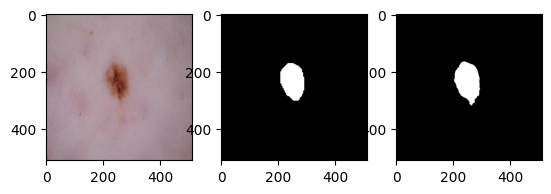

In [ ]:
#predict
VOC_COLORMAP = [[0, 0, 0], [255, 255, 255]]
import random
id = random.randint(0, 1000)
with torch.no_grad():
    model.eval()
    x, y = dataset_test.__getitem__(id)
    y_predict = F.interpolate(model(x.unsqueeze(0).to(device)).logits, size=y.shape, mode="bilinear").argmax(dim=1).squeeze().cpu().numpy()
    print(np.unique(y_predict))
    print(y_predict.shape)
    color_mask_predict = np.zeros((*y_predict.shape, 3))
    for i, color in enumerate(VOC_COLORMAP):
        color_mask_predict[y_predict==i] = np.array(color)
    color_mask = np.zeros((*y_predict.shape, 3))
    for i, color in enumerate(VOC_COLORMAP):
        color_mask[y==i] = np.array(color)
    plt.subplot(1,3,1)
    plt.imshow(unorm(x).permute(1, 2, 0))
    plt.subplot(1,3,2)
    plt.imshow(color_mask)
    plt.subplot(1,3,3)
    plt.imshow(color_mask_predict)
    plt.show()